In [1]:
import cv2
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt

In [2]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, input_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (input_size, input_size))
    image = preprocess_input(image)
    return image


In [3]:
# Load images and labels
def load_data(image_dir):
    dataset = []
    labels = []
    label_map = {'No': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Proliferate': 4}
    for label_name in label_map.keys():
        image_paths = os.listdir(os.path.join(image_dir, label_name))
        for image_name in image_paths:
            if image_name.endswith('.png'):
                image_path = os.path.join(image_dir, label_name, image_name)
                image = load_and_preprocess_image(image_path, INPUT_SIZE)
                dataset.append(image)
                labels.append(label_map[label_name])
    return np.array(dataset), np.array(labels)

In [ ]:
image_directory = 'dataset/'

In [5]:
INPUT_SIZE = 224

In [6]:
dataset, labels = load_data(image_directory)

In [7]:
train_images, test_images, train_labels, test_labels = train_test_split(dataset, labels, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

In [8]:
base_model = DenseNet121(input_shape=(INPUT_SIZE, INPUT_SIZE, 3), include_top=False, weights='imagenet')

In [9]:
base_model.trainable = False  # Freeze all layers by default

In [10]:
# Optionally, select layers to unfreeze for fine-tuning (e.g., base_model.layers[-10:] are the last 10 layers)
for layer in base_model.layers[-10:]:
    layer.trainable = True

In [11]:
# Add custom classification head
global_average_layer = layers.GlobalAveragePooling2D()
dropout = layers.Dropout(0.5)  # Add dropout for regularization
output_layer = layers.Dense(5, activation='softmax')

In [12]:
# Create the model
from tensorflow.keras import models
model = models.Sequential([
  base_model,
  global_average_layer,
  dropout,
  output_layer
])

In [14]:
model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

ValueError: Argument(s) not recognized: {'lr': 1e-05}

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 7042629 (26.87 MB)
Trainable params: 5125 (20.02 KB)
Non-trainable params: 7037504 (26.85 MB)
_________________________________________________________________


In [ ]:
history = model.fit(train_images, train_labels,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_images, val_labels),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])

Epoch 1/15



76/76 [==============================] - 65s 795ms/step - loss: 1.4405 - accuracy: 0.5000 - val_loss: 0.9694 - val_accuracy: 0.6578
Epoch 2/15
76/76 [==============================] - 55s 722ms/step - loss: 1.0670 - accuracy: 0.6204 - val_loss: 0.8696 - val_accuracy: 0.6827
Epoch 3/15
76/76 [==============================] - 55s 724ms/step - loss: 0.9562 - accuracy: 0.6628 - val_loss: 0.8016 - val_accuracy: 0.7076
Epoch 4/15
76/76 [==============================] - 55s 724ms/step - loss: 0.8787 - accuracy: 0.6844 - val_loss: 0.7467 - val_accuracy: 0.7209
Epoch 5/15
76/76 [==============================] - 59s 777ms/step - loss: 0.8334 - accuracy: 0.6931 - val_loss: 0.7137 - val_accuracy: 0.7309
Epoch 6/15
76/76 [==============================] - 58s 761ms/step - loss: 0.7981 - accuracy: 0.7089 - val_loss: 0.7084 - val_accuracy: 0.7375
Epoch 7/15
76/76 [==============================] - 56s 741ms/step - loss: 0.7816 - accuracy: 0.7010 - val_loss: 0.6844 - val_accuracy: 0.7492
Epoch 8/15

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

24/24 [==============================] - 14s 587ms/step - loss: 0.5298 - accuracy: 0.8181
Test accuracy: 0.818061113357544


In [ ]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


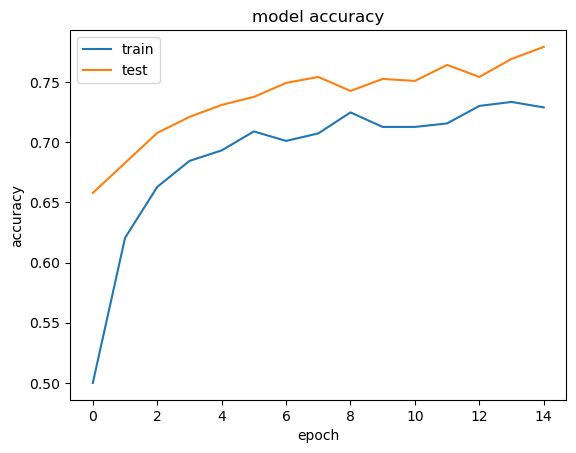

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

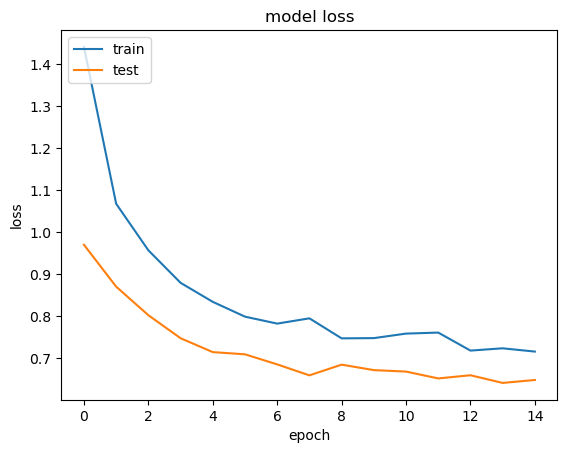

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

24/24 [==============================] - 16s 577ms/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
cm = confusion_matrix(test_labels, predicted_labels)

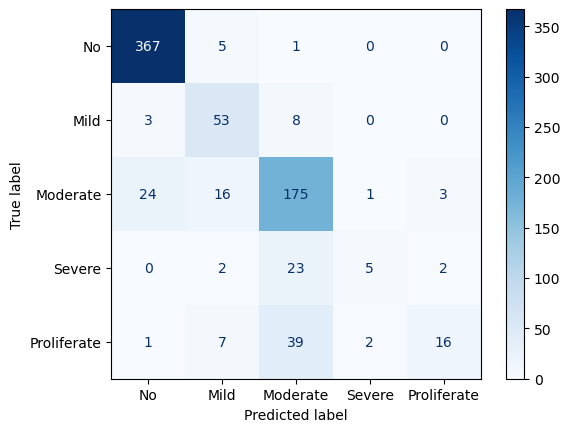

In [ ]:
# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Mild', 'Moderate', 'Severe', 'Proliferate'])
disp.plot(cmap=plt.cm.Blues)
plt.show()